In [ ]:
# Fixed and tested-looking Pareto pipeline (syntactically clean)
# Save as pareto_pipeline_fixed.py and run in an environment with xpress, numpy, pandas, matplotlib

import xpress as xp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from typing import List, Dict, Optional

# --------------------------- USER CONFIG ---------------------------
POIS_PATH = 'reduced_pois2.csv'
STATIONS_TEMPLATE = 'candidate_stations_P300_type_{}.csv'
DEMAND_TEMPLATE = 'poi_demand_per_hour_type_{}_cluster{}.csv'
EXISTING_STATION_DATA = 'station_data.csv'

STRATEGIES = ['uniform', 'commercial']

INITIAL_BUDGET = 13_000_000
MIN_BUDGET = 100_000
BUDGET_STEP = 800_000

Tau = 2
k = 1000

COST_EXISTING = 60000
COST_NEW = 90000
ALPHA = 0.7

W_C = {
    'library': 0.8,
    'residential': 0.75,
    'school': 0.85,
    'commercial': 0.9,
    'university': 0.95,
    'hospital': 0.98
}

XPRESS_VERBOSE = False
OUTPUT_DIR = 'pareto_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------- UTILITIES ---------------------------

def haversine_matrix(pois: pd.DataFrame,
                     stations: pd.DataFrame,
                     poi_lat: str = 'lat', poi_lon: str = 'lon',
                     st_lat: str = 'centroid_lat', st_lon: str = 'centroid_lon') -> np.ndarray:
    """Compute POI x Station distance matrix (km)."""
    poi_coords = pois[[poi_lat, poi_lon]].to_numpy()
    st_coords = stations[[st_lat, st_lon]].to_numpy()
    lat1 = np.radians(poi_coords[:, 0])[:, None]
    lon1 = np.radians(poi_coords[:, 1])[:, None]
    lat2 = np.radians(st_coords[:, 0])[None, :]
    lon2 = np.radians(st_coords[:, 1])[None, :]
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371.0
    return R * c

# --------------------------- MODEL BUILDER ---------------------------

def build_and_solve_model(distance_matrix_km: np.ndarray,
                          stations: pd.DataFrame,
                          pois: pd.DataFrame,
                          demand_scenarios: List[List[float]],
                          capacity_vector: np.ndarray,
                          cost_vector: np.ndarray,
                          I_c: Dict[str, List[int]],
                          w_c: Dict[str, float],
                          Tau: float,
                          k: float,
                          budget_limit: float,
                          verbose: bool = False) -> Optional[Dict]:
    I, J = distance_matrix_km.shape
    prob = xp.problem(name='pcentre_modular_run')

    # Variables
    Y = {j: prob.addVariable(vartype=xp.binary, name=f'Y_{j}') for j in range(J)}
    X = {(i, j): prob.addVariable(vartype=xp.binary, name=f'X_{i}_{j}') for i in range(I) for j in range(J)}
    Z = {j: prob.addVariable(vartype=xp.integer, name=f'Z_{j}') for j in range(J)}
    Q = prob.addVariable(name='Q', lb=0)

    # Constraints
    for i in range(I):
        prob.addConstraint(xp.Sum(X[i, j] for j in range(J)) <= 1)

    for i in range(I):
        for j in range(J):
            prob.addConstraint(X[i, j] <= Y[j])

    for i in range(I):
        prob.addConstraint(xp.Sum(distance_matrix_km[i, j] * X[i, j] for j in range(J)) <= Q)

    prob.addConstraint(
        xp.Sum(cost_vector[j] * Y[j] for j in range(J))
        + k * xp.Sum((Z[j] - capacity_vector[j] * Y[j]) for j in range(J))
        <= budget_limit
    )

    for j in range(J):
        prob.addConstraint(Z[j] >= capacity_vector[j] * Y[j])
        prob.addConstraint(Z[j] <= 100 * Y[j])
        for s in range(len(demand_scenarios)):
            ds = demand_scenarios[s]
            prob.addConstraint(xp.Sum(X[i, j] * ds[i] for i in range(I)) <= Tau * Z[j])

    for s in range(len(demand_scenarios)):
        ds = demand_scenarios[s]
        # Option B: Binary hit-based service level (% of POIs in category served)
        for c, idx_list in I_c.items():
            if not idx_list:
                continue
            lhs = xp.Sum(xp.Sum(X[i, j] for j in range(J)) for i in idx_list)
            rhs = w_c[c] * len(idx_list)
            prob.addConstraint(lhs >= rhs)

    prob.setObjective(Q, sense=xp.minimize)

    xp.setOutputEnabled(verbose)
    try:
        prob.solve()
    except Exception as e:
        if verbose:
            print('Solver failed:', e)
        return None

    try:
        Q_val = prob.getSolution(Q)
    except Exception:
        return None

    Y_sol = np.array([prob.getSolution(Y[j]) for j in range(J)])
    Z_sol = np.array([prob.getSolution(Z[j]) for j in range(J)])

    budget_used = float(np.dot(cost_vector, Y_sol) + k * np.sum(Z_sol - capacity_vector * Y_sol))
    opened_count = int((Y_sol > 0.5).sum())

    opened_indices = [int(j) for j in range(J) if Y_sol[j] > 0.5]
    Z_values_opened = {int(j): int(Z_sol[j]) for j in opened_indices}

    return {'problem': prob,
            'Q': Q_val,
            'Y_sol': Y_sol,
            'Z_sol': Z_sol,
            'budget_used': budget_used,
            'opened': opened_count,
            'opened_indices': opened_indices,
            'Z_values_opened': Z_values_opened}

# --------------------------- PARETO FOR STRATEGY (logged + store) ---------------------------

def pareto_for_strategy_store(strategy: str,
                              pois_path: str,
                              stations_template: str,
                              demand_template: str,
                              existing_station_data_path: str,
                              initial_budget: int = INITIAL_BUDGET,
                              min_budget: int = MIN_BUDGET,
                              budget_step: int = BUDGET_STEP,
                              Tau: float = Tau,
                              k: float = k,
                              w_c: Dict[str, float] = W_C,
                              alpha: float = ALPHA,
                              cost_existing: float = COST_EXISTING,
                              cost_new: float = COST_NEW,
                              verbose: bool = XPRESS_VERBOSE) -> Optional[pd.DataFrame]:
    pois = pd.read_csv(pois_path)
    stations = pd.read_csv(stations_template.format(strategy))
    D_km = haversine_matrix(pois, stations)

    # nearest-POI category assignment
    poi_categories = pois['category'].reset_index(drop=True)
    min_row_idx_for_station = np.argmin(D_km, axis=0)
    station_categories = poi_categories.iloc[min_row_idx_for_station].reset_index(drop=True)
    stations['category'] = station_categories.values

    categories = list(w_c.keys())
    I_c = {c: pois.index[pois['category'] == c].tolist() for c in categories}

    demand_scenarios: List[List[float]] = []
    for i in range(4):
        df = pd.read_csv(demand_template.format(strategy, i))
        demand_scenarios.append(df['demand_per_hour'].tolist())

    existing_data = pd.read_csv(existing_station_data_path)
    capacity_map = dict(zip(existing_data['station_id'], existing_data['capacity']))
    capacity_vector = np.array([capacity_map.get(sid, 10) for sid in stations['snapped_station_id']])

    is_existing = stations['is_existing_station'].astype(bool).values
    station_is_commercial_by_nearest = (stations['category'] == 'commercial').values

    J = stations.shape[0]
    cost_vector = np.zeros(J, dtype=float)
    for j in range(J):
        if is_existing[j] and station_is_commercial_by_nearest[j]:
            cost_vector[j] = alpha * cost_existing
        elif is_existing[j]:
            cost_vector[j] = cost_existing
        elif station_is_commercial_by_nearest[j]:
            cost_vector[j] = alpha * cost_new
        else:
            cost_vector[j] = cost_new

    # Budgets descending (high -> low)
    budgets = list(range(int(initial_budget), int(min_budget) - 1, -int(budget_step)))
    results = []
    detailed_solutions = []

    for b in budgets:
        print(f"[Strategy={strategy}] Attempting budget limit = £{b:,}")
        sol = build_and_solve_model(D_km, stations, pois, demand_scenarios,
                                    capacity_vector, cost_vector, I_c, w_c,
                                    Tau, k, float(b), verbose=verbose)
        if sol is None:
            print(f"[Strategy={strategy}] No feasible solution at budget £{b:,}")
            continue

        print(f"[Strategy={strategy}] Solved: budget_limit=£{b:,} -> budget_used=£{sol['budget_used']:.2f}, Q={sol['Q']:.4f} km, opened={sol['opened']} stations")

        results.append({'strategy': strategy, 'budget_limit': b, 'budget_used': sol['budget_used'], 'Q': sol['Q'], 'opened': sol['opened']})

        detailed_solutions.append({
            'strategy': strategy,
            'budget_limit': int(b),
            'budget_used': float(sol['budget_used']),
            'Q': float(sol['Q']),
            'opened_count': int(sol['opened']),
            'opened_indices': sol['opened_indices'],
            'Z_values_opened': sol['Z_values_opened']
        })

    # Save detailed solutions
    if detailed_solutions:
        det_csv = os.path.join(OUTPUT_DIR, f'detailed_solutions_{strategy}.csv')
        det_pkl = os.path.join(OUTPUT_DIR, f'detailed_solutions_{strategy}.pkl')
        pd.DataFrame(detailed_solutions).to_csv(det_csv, index=False)
        with open(det_pkl, 'wb') as f:
            pickle.dump(detailed_solutions, f)
        print(f"Saved detailed solutions for strategy {strategy} to {det_csv} and {det_pkl}")

    if len(results) == 0:
        return None

    df = pd.DataFrame(results).sort_values('budget_used', ascending=True).reset_index(drop=True)
    df.to_csv(os.path.join(OUTPUT_DIR, f'pareto_points_{strategy}.csv'), index=False)
    print(f"Saved pareto points for strategy {strategy} to {os.path.join(OUTPUT_DIR, f'pareto_points_{strategy}.csv')}")

    return df

# --------------------------- DOMINATION CHECK ---------------------------

def find_nondominated(df_all: pd.DataFrame) -> pd.DataFrame:
    pts = df_all[['budget_used', 'Q']].to_numpy()
    n = pts.shape[0]
    is_nd = np.ones(n, dtype=bool)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if (pts[j, 0] <= pts[i, 0] and pts[j, 1] <= pts[i, 1]) and (pts[j, 0] < pts[i, 0] or pts[j, 1] < pts[i, 1]):
                is_nd[i] = False
                break
    return df_all[is_nd].reset_index(drop=True)

# --------------------------- MAIN: RUN ALL + PLOT + STORE DOMINANT ---------------------------

def run_all_and_store_dominant(strategies: List[str] = STRATEGIES):
    per_strategy_dfs: Dict[str, pd.DataFrame] = {}

    for s in strategies:
        print('\n' + '=' * 70)
        print(f"Starting strategy: {s}")
        df = pareto_for_strategy_store(s, POIS_PATH, STATIONS_TEMPLATE, DEMAND_TEMPLATE, EXISTING_STATION_DATA,
                                      initial_budget=INITIAL_BUDGET, min_budget=MIN_BUDGET, budget_step=BUDGET_STEP,
                                      Tau=Tau, k=k, w_c=W_C, alpha=ALPHA, cost_existing=COST_EXISTING,
                                      cost_new=COST_NEW, verbose=XPRESS_VERBOSE)
        if df is None or df.empty:
            print(f"Strategy {s} produced no feasible points.")
            continue
        per_strategy_dfs[s] = df

    # Save per-strategy files already saved in function; combine
    all_dfs: List[pd.DataFrame] = []
    for s, df in per_strategy_dfs.items():
        tmp = df.copy()
        tmp['strategy'] = s
        all_dfs.append(tmp)

    if not all_dfs:
        print('No solutions found across strategies.')
        return

    df_all = pd.concat(all_dfs, ignore_index=True)
    df_all_path = os.path.join(OUTPUT_DIR, 'pareto_points_all_strategies.csv')
    df_all.to_csv(df_all_path, index=False)
    print(f'Saved all pareto points to {df_all_path}')

    # Find non-dominated
    df_nd = find_nondominated(df_all)
    nd_path = os.path.join(OUTPUT_DIR, 'pareto_points_nondominated.csv')
    df_nd.to_csv(nd_path, index=False)
    print(f'Saved nondominated (global Pareto) points to {nd_path}')

    # Save detailed dominant solutions from per-strategy pickles
    dominant_details = []
    for _, row in df_nd.iterrows():
        strat = row['strategy']
        pkl_path = os.path.join(OUTPUT_DIR, f'detailed_solutions_{strat}.pkl')
        if not os.path.exists(pkl_path):
            continue
        with open(pkl_path, 'rb') as f:
            det_list = pickle.load(f)
        # find entry with closest budget_used
        best = None
        min_diff = float('inf')
        for det in det_list:
            diff = abs(det['budget_used'] - row['budget_used'])
            if diff < min_diff:
                min_diff = diff
                best = det
        if best is not None:
            best_copy = best.copy()
            best_copy['strategy'] = strat
            dominant_details.append(best_copy)

    dominant_csv = os.path.join(OUTPUT_DIR, 'dominant_solutions_detailed.csv')
    dominant_pkl = os.path.join(OUTPUT_DIR, 'dominant_solutions_detailed.pkl')
    if dominant_details:
        pd.DataFrame(dominant_details).to_csv(dominant_csv, index=False)
        with open(dominant_pkl, 'wb') as f:
            pickle.dump(dominant_details, f)
        print(f'Saved dominant solution details to {dominant_csv} and {dominant_pkl}')
    else:
        print('No detailed dominant solutions found to save')

    # Side-by-side plot
    n = len(strategies)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)
    if n == 1:
        axes = [axes]
    for ax, s in zip(axes, strategies):
        df = per_strategy_dfs.get(s)
        if df is None or df.empty:
            ax.set_title(s + ' (no points)')
            continue
        ax.scatter(df['budget_used'], df['Q'], marker='o')
        for _, row in df.iterrows():
            ax.annotate(f"Q={row['Q']:.3f}\n£{row['budget_used']:.0f}\nopen={row['opened']}",
                        (row['budget_used'], row['Q']), textcoords='offset points', xytext=(3, 3), fontsize=8)
        ax.set_title(s)
        ax.set_xlabel('Budget used (£)')
        ax.grid(True)
    axes[0].set_ylabel('Q (km)')
    plt.suptitle('Per-strategy Pareto points (Budget used vs Q)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    side_by_side_path = os.path.join(OUTPUT_DIR, 'pareto_per_strategy_side_by_side.png')
    plt.savefig(side_by_side_path, dpi=200)
    print(f'Saved side-by-side figure: {side_by_side_path}')

    # Combined plot with nondominated highlighted
    plt.figure(figsize=(9, 6))
    for s in strategies:
        sub = df_all[df_all['strategy'] == s]
        if sub.empty:
            continue
        plt.scatter(sub['budget_used'], sub['Q'], label=s, alpha=0.4)
    if not df_nd.empty:
        plt.scatter(df_nd['budget_used'], df_nd['Q'], color='red', s=100, label='Global Pareto (nondominated)')
        for _, row in df_nd.iterrows():
            plt.annotate(f"{row['strategy']}\nQ={row['Q']:.3f}\n£{row['budget_used']:.0f}",
                         (row['budget_used'], row['Q']), textcoords='offset points', xytext=(5, -5), fontsize=9)
    plt.xlabel('Budget used (£)')
    plt.ylabel('Q (km)')
    plt.title('Combined solutions and global Pareto (nondominated)')
    plt.legend()
    plt.grid(True)
    combined_path = os.path.join(OUTPUT_DIR, 'pareto_combined_nondominated.png')
    plt.tight_layout()
    plt.savefig(combined_path, dpi=200)
    print(f'Saved combined Pareto figure with nondominated highlighted: {combined_path}')

    print('\nGLOBAL NONDOMINATED SOLUTIONS:')
    print(df_nd)
    print('\nDetailed dominant solutions saved (if any) to:')
    print(dominant_csv)
    print(dominant_pkl)


In [2]:

# --------------------------- ENTRYPOINT ---------------------------
if __name__ == '__main__':
    run_all_and_store_dominant(STRATEGIES)



Starting strategy: uniform
[Strategy=uniform] Attempting budget limit = £13,000,000


/var/folders/tn/v19h6ld131n5p0bkj6b850sr0000gn/T/ipykernel_88716/873076804.py:79: LicenseWarning: Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
  prob = xp.problem(name='pcentre_modular_run')


[Strategy=uniform] Solved: budget_limit=£13,000,000 -> budget_used=£12994000.00, Q=0.7458 km, opened=162 stations
[Strategy=uniform] Attempting budget limit = £12,200,000
[Strategy=uniform] Solved: budget_limit=£12,200,000 -> budget_used=£12200000.00, Q=0.7458 km, opened=156 stations
[Strategy=uniform] Attempting budget limit = £11,400,000
[Strategy=uniform] Solved: budget_limit=£11,400,000 -> budget_used=£11398000.00, Q=0.7458 km, opened=148 stations
[Strategy=uniform] Attempting budget limit = £10,600,000
[Strategy=uniform] Solved: budget_limit=£10,600,000 -> budget_used=£10600000.00, Q=0.7458 km, opened=137 stations
[Strategy=uniform] Attempting budget limit = £9,800,000
[Strategy=uniform] Solved: budget_limit=£9,800,000 -> budget_used=£9800000.00, Q=0.7458 km, opened=126 stations
[Strategy=uniform] Attempting budget limit = £9,000,000
[Strategy=uniform] Solved: budget_limit=£9,000,000 -> budget_used=£9000000.00, Q=0.7458 km, opened=115 stations
[Strategy=uniform] Attempting budget 

InterfaceError: Unidentified error associated with the global environment

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
CSV_ALL = 'pareto_outputs/pareto_points_all_strategies.csv'
CSV_ND = 'pareto_outputs/dominant_solutions_detailed.csv'

# Read data
df_all = pd.read_csv(CSV_ALL)
df_nd = pd.read_csv(CSV_ND)
df_nd = df_nd.sort_values("budget_used")   # <-- FIX

# Sort for cleaner lines
df_all = df_all.sort_values(['strategy', 'budget_used'])

# Plot
plt.figure(figsize=(10,7))

# Line + scatter for each strategy
strategies = df_all['strategy'].unique()
for s in strategies:
    sub = df_all[df_all['strategy'] == s].sort_values('budget_used')
    plt.plot(sub['budget_used'], sub['Q'], label=f"{s} (line)")
    plt.scatter(sub['budget_used'], sub['Q'], s=25)

# Global Pareto nondominated
plt.plot(df_nd['budget_used'], df_nd['Q'], color='black', linewidth=2.2, label='Global Pareto frontier')
plt.scatter(df_nd['budget_used'], df_nd['Q'], s=50, color='black')

plt.xlabel('Budget used (£)')
plt.ylabel('Q (km)')
plt.title('Pareto Fronts')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('pareto_outputs/replot_clean.png', dpi=200)

FileNotFoundError: [Errno 2] No such file or directory: 'pareto_outputs/pareto_points_all_strategies.csv'

Percentage of nondominated points per strategy:
 strategy
uniform       56.521739
pred          26.086957
commercial    17.391304
Name: proportion, dtype: float64

Nondominated summary table:
       strategy  budget_used         Q
17        pred     186000.0  2.460643
18        pred     495000.0  1.260085
13  commercial     774000.0  0.935904
0      uniform     795000.0  0.893317
14  commercial    1083000.0  0.708092
1      uniform    1084000.0  0.690303
19        pred    1086000.0  0.669469
2      uniform    1395000.0  0.586990
3      uniform    1686000.0  0.487054
20        pred    1695000.0  0.487054
4      uniform    1995000.0  0.424232
21        pred    1998000.0  0.421894
22        pred    2287000.0  0.370661
5      uniform    2589000.0  0.332083
15  commercial    2895000.0  0.298937
6      uniform    3195000.0  0.282666
16  commercial    3198000.0  0.268132
7      uniform    3477000.0  0.257912
8      uniform    3798000.0  0.243337
9      uniform    4098000.0  0.230124
10     un

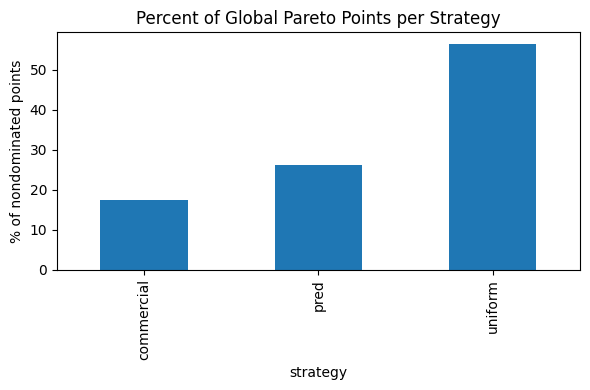

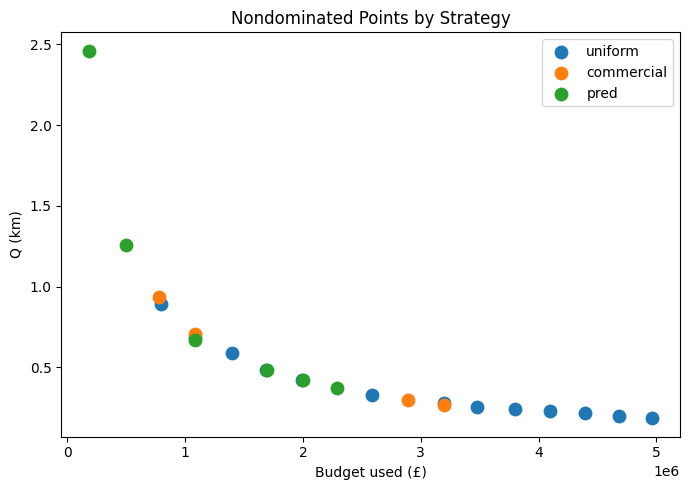

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load nondominated CSV and all points
nd = pd.read_csv('pareto_outputs/pareto_points_nondominated.csv')
allpts = pd.read_csv('pareto_outputs/pareto_points_all_strategies.csv')

# Percentage of global-optimal (nondominated) points per strategy
pct = nd['strategy'].value_counts(normalize=True) * 100
print("Percentage of nondominated points per strategy:\n", pct)

# Table summarizing budgets + Q for nondominated points
summary = nd[['strategy','budget_used','Q']].sort_values('budget_used')
print("\nNondominated summary table:\n", summary)

# Bar plot of pct
plt.figure(figsize=(6,4))
pct.sort_values().plot(kind='bar')
plt.ylabel('% of nondominated points')
plt.title('Percent of Global Pareto Points per Strategy')
plt.tight_layout()
plt.savefig('pareto_outputs/nondominated_scatter_by_strategy-pct.png', dpi=200)
# plt.showfig('pareto_outputs/percent_nondominated_per_strategy.png', dpi=200)
# plt.show()

# Scatter plot of nondominated points colored by strategy
plt.figure(figsize=(7,5))
for s in nd['strategy'].unique():
    sub = nd[nd['strategy']==s]
    
    plt.scatter(sub['budget_used'], sub['Q'], label=s, s=80)
plt.xlabel('Budget used (£)')
plt.ylabel('Q (km)')
plt.legend()
plt.title('Nondominated Points by Strategy')
plt.tight_layout()
plt.savefig('pareto_outputs/nondominated_scatter_by_strategy.png', dpi=200)
# plt.showfig('pareto_outputs/percent_nondominated_per_strategy.png', dpi=200)
# plt.show()


In [ ]:
"""
alpha_sensitivity_commercial.py

Run sensitivity analysis on ALPHA for strategy 'commercial' and a fixed budget.
Assumes your main pipeline is in pareto_pipeline_fixed.py and exposes the functions:
 - build_and_solve_model

If you placed the full pipeline in a different filename, change the import accordingly.

This script will:
 - load POIs, stations, demand scenarios and existing station data
 - for each alpha in the chosen grid, build the cost_vector (same logic as in your pipeline)
 - call build_and_solve_model once with budget_limit = target_budget
 - record Q, budget_used, opened and feasibility
 - save results to CSV and produce a plot Q vs alpha

Usage: python alpha_sensitivity_commercial.py
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict



os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------- User selections --------------------
strategy = "uniform"
target_budget = 10_600_000  # fixed budget limit to re-run for
alpha_grid = np.linspace(0.4, 1.0, 10)

# -------------------- Helper to load data --------------------
def load_data_for_strategy(strategy: str):
    pois = pd.read_csv(POIS_PATH)
    stations = pd.read_csv(STATIONS_TEMPLATE.format(strategy))
    # compute distance matrix once
    D_km = haversine_matrix(pois, stations)

    # nearest POI category assignment (same logic as in your pipeline)
    poi_categories = pois['category'].reset_index(drop=True)
    min_row_idx_for_station = np.argmin(D_km, axis=0)
    station_categories = poi_categories.iloc[min_row_idx_for_station].reset_index(drop=True)
    stations['category'] = station_categories.values

    categories = list(W_C.keys())
    I_c = {c: pois.index[pois['category'] == c].tolist() for c in categories}

    # load demand scenarios (4 files expected)
    demand_scenarios: List[List[float]] = []
    for i in range(4):
        df = pd.read_csv(DEMAND_TEMPLATE.format(strategy, i))
        demand_scenarios.append(df['demand_per_hour'].tolist())

    existing_data = pd.read_csv(EXISTING_STATION_DATA)
    capacity_map = dict(zip(existing_data['station_id'], existing_data['capacity']))
    capacity_vector = np.array([capacity_map.get(sid, 10) for sid in stations['snapped_station_id']])

    is_existing = stations['is_existing_station'].astype(bool).values
    station_is_commercial_by_nearest = (stations['category'] == 'commercial').values

    return {
        'pois': pois,
        'stations': stations,
        'D_km': D_km,
        'I_c': I_c,
        'demand_scenarios': demand_scenarios,
        'capacity_vector': capacity_vector,
        'is_existing': is_existing,
        'station_is_commercial_by_nearest': station_is_commercial_by_nearest
    }

# -------------------- Run sensitivity --------------------

def run_alpha_sensitivity(strategy: str, target_budget: float, alpha_grid: np.ndarray):
    data = load_data_for_strategy(strategy)
    pois = data['pois']
    stations = data['stations']
    D_km = data['D_km']
    I_c = data['I_c']
    demand_scenarios = data['demand_scenarios']
    capacity_vector = data['capacity_vector']
    is_existing = data['is_existing']
    station_is_commercial_by_nearest = data['station_is_commercial_by_nearest']

    J = stations.shape[0]

    results = []

    for alpha in alpha_grid:
        print(f"Running alpha={alpha:.4f} ...")
        # build cost vector the same way as in your pipeline but using this alpha
        cost_vector = np.zeros(J, dtype=float)
        for j in range(J):
            if is_existing[j] and station_is_commercial_by_nearest[j]:
                cost_vector[j] = alpha * COST_EXISTING
            elif is_existing[j]:
                cost_vector[j] = COST_EXISTING
            elif station_is_commercial_by_nearest[j]:
                cost_vector[j] = alpha * COST_NEW
            else:
                cost_vector[j] = COST_NEW

        sol = build_and_solve_model(D_km, stations, pois, demand_scenarios,
                                    capacity_vector, cost_vector, I_c, W_C,
                                    Tau, k, float(target_budget), verbose=False)

        if sol is None:
            print(f"alpha={alpha:.4f} -> infeasible or solver failure")
            results.append({'alpha': float(alpha), 'feasible': False, 'Q': np.nan,
                            'budget_used': np.nan, 'opened': np.nan, 'opened_indices': None})
            continue

        results.append({'alpha': float(alpha),
                        'feasible': True,
                        'Q': float(sol['Q']),
                        'budget_used': float(sol['budget_used']),
                        'opened': int(sol['opened']),
                        'opened_indices': sol['opened_indices']})

    return pd.DataFrame(results)

Running alpha=0.4000 ...


C:\Users\frequensy\AppData\Local\Temp\ipykernel_14844\1626295403.py:79: LicenseWarning: Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('C:/xpressmp//bin/xpauth.xpr')
  prob = xp.problem(name='pcentre_modular_run')


Running alpha=0.4667 ...
Running alpha=0.5333 ...
Running alpha=0.6000 ...
Running alpha=0.6667 ...
Running alpha=0.7333 ...
Running alpha=0.8000 ...
Running alpha=0.8667 ...
Running alpha=0.9333 ...
Running alpha=1.0000 ...
Saved results to: pareto_outputs\alpha_sensitivity_uniform_1395000.csv
Saved plot to: pareto_outputs\alpha_sensitivity_uniform_1395000.png

Summary:
      alpha  feasible         Q  budget_used  opened  \
0  0.400000      True  0.469037    1386000.0      34   
1  0.466667      True  0.486264    1394000.0      31   
2  0.533333      True  0.504180    1392000.0      28   
3  0.600000      True  0.562610    1392000.0      27   
4  0.666667      True  0.586990    1390000.0      26   
5  0.733333      True  0.595956    1392000.0      25   
6  0.800000      True  0.601767    1392000.0      23   
7  0.866667      True  0.601853    1394000.0      23   
8  0.933333      True  0.621993    1382000.0      22   
9  1.000000      True  0.628432    1380000.0      22   

         

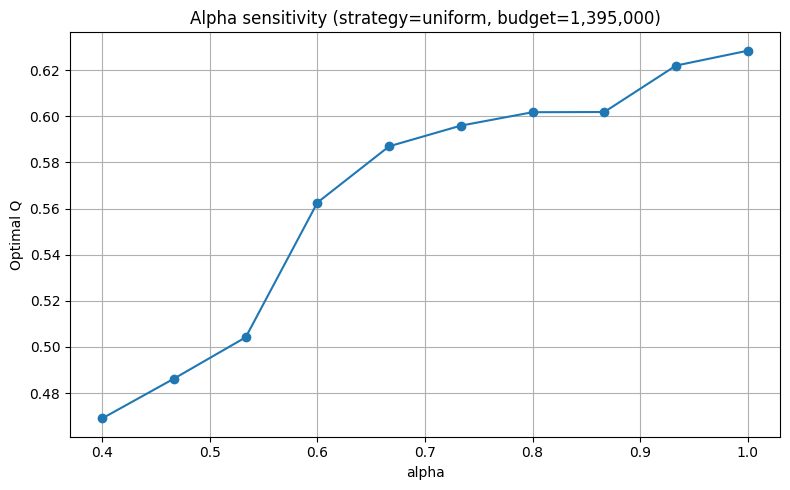

In [ ]:


# -------------------- Main --------------------
if __name__ == '__main__':
    df_res = run_alpha_sensitivity(strategy, target_budget, alpha_grid)
    out_csv = os.path.join(OUTPUT_DIR, f'alpha_sensitivity_{strategy}_{int(target_budget)}.csv')
    df_res.to_csv(out_csv, index=False)
    print(f"Saved results to: {out_csv}")

    # Plot Q vs alpha (only feasible points)
    plt.figure(figsize=(8, 5))
    feasible = df_res['feasible'] == True
    plt.plot(df_res.loc[feasible, 'alpha'], df_res.loc[feasible, 'Q'], marker='o', linestyle='-')
    plt.scatter(df_res.loc[~feasible, 'alpha'], np.zeros((~feasible).sum()), marker='x', color='red', label='infeasible')
    plt.xlabel('alpha')
    plt.ylabel('Optimal Q')
    plt.title(f'Alpha sensitivity (strategy={strategy}, budget={target_budget:,.0f})')
    plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, f'alpha_sensitivity_{strategy}_{int(target_budget)}.png')
    plt.savefig(plot_path, dpi=200)
    print(f"Saved plot to: {plot_path}")

    print('\nSummary:')
    print(df_res)


In [ ]:
"""
This script provides two additional sensitivity analyses:
1. Tau sensitivity: vary the global Tau parameter while keeping other parameters fixed.
2. W-vector sensitivity (service level by category): vary each category's weight W_C[c] individually (scale it by a factor) while keeping the others constant.

It mirrors the structure of the alpha_sensitivity script you shared.

Assumes the same imported functions and data structures from pareto_pipeline_fixed.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict


os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------- Shared loader --------------------
def load_data_for_strategy(strategy: str):
    pois = pd.read_csv(POIS_PATH)
    stations = pd.read_csv(STATIONS_TEMPLATE.format(strategy))
    D_km = haversine_matrix(pois, stations)
    poi_categories = pois['category'].reset_index(drop=True)
    min_row_idx_for_station = np.argmin(D_km, axis=0)
    station_categories = poi_categories.iloc[min_row_idx_for_station].reset_index(drop=True)
    stations['category'] = station_categories.values
    categories = list(W_C.keys())
    I_c = {c: pois.index[pois['category'] == c].tolist() for c in categories}
    demand_scenarios = []
    for i in range(4):
        df = pd.read_csv(DEMAND_TEMPLATE.format(strategy, i))
        demand_scenarios.append(df['demand_per_hour'].tolist())
    existing_data = pd.read_csv(EXISTING_STATION_DATA)
    capacity_map = dict(zip(existing_data['station_id'], existing_data['capacity']))
    capacity_vector = np.array([capacity_map.get(sid, 10) for sid in stations['snapped_station_id']])
    is_existing = stations['is_existing_station'].astype(bool).values
    station_is_commercial_by_nearest = (stations['category'] == 'commercial').values
    return {
        'pois': pois,
        'stations': stations,
        'D_km': D_km,
        'I_c': I_c,
        'demand_scenarios': demand_scenarios,
        'capacity_vector': capacity_vector,
        'is_existing': is_existing,
        'station_is_commercial_by_nearest': station_is_commercial_by_nearest
    }

# -------------------- Tau sensitivity --------------------
def run_tau_sensitivity(strategy: str, target_budget: float, tau_grid: np.ndarray):
    data = load_data_for_strategy(strategy)
    pois = data['pois']; stations = data['stations']; D_km = data['D_km']
    I_c = data['I_c']; demand_scenarios = data['demand_scenarios']
    capacity_vector = data['capacity_vector']; is_existing = data['is_existing']
    station_is_commercial_by_nearest = data['station_is_commercial_by_nearest']

    J = stations.shape[0]

    # cost vector independent of Tau
    cost_vector = np.zeros(J, dtype=float)
    for j in range(J):
        if is_existing[j] and station_is_commercial_by_nearest[j]:
            cost_vector[j] = COST_EXISTING
        elif is_existing[j]:
            cost_vector[j] = COST_EXISTING
        elif station_is_commercial_by_nearest[j]:
            cost_vector[j] = COST_NEW
        else:
            cost_vector[j] = COST_NEW

    results = []
    for tau_val in tau_grid:
        print(f"Running Tau={tau_val:.4f} ...")
        sol = build_and_solve_model(
            D_km, stations, pois, demand_scenarios, capacity_vector,
            cost_vector, I_c, W_C, tau_val, k, float(target_budget), verbose=False
        )
        if sol is None:
            results.append({'Tau': float(tau_val), 'feasible': False, 'Q': np.nan,
                            'budget_used': np.nan, 'opened': np.nan})
        else:
            results.append({'Tau': float(tau_val), 'feasible': True,
                            'Q': float(sol['Q']), 'budget_used': float(sol['budget_used']),
                            'opened': int(sol['opened'])})
    return pd.DataFrame(results)



In [ ]:

# -------------------- Example main --------------------
if __name__ == '__main__':
    strategy = 'uniform'
    target_budget = 10_600_000

    tau_grid = np.linspace(0.5, 3, 10)
    df_tau = run_tau_sensitivity(strategy, target_budget, tau_grid)
    df_tau.to_csv(os.path.join(OUTPUT_DIR, 'tau_sensitivity.csv'), index=False)


Running Tau=0.5000 ...


C:\Users\frequensy\AppData\Local\Temp\ipykernel_18112\1626295403.py:79: LicenseWarning: Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('C:/xpressmp//bin/xpauth.xpr')
  prob = xp.problem(name='pcentre_modular_run')


Running Tau=0.7778 ...
Running Tau=1.0556 ...
Running Tau=1.3333 ...
Running Tau=1.6111 ...
Running Tau=1.8889 ...
Running Tau=2.1667 ...
Running Tau=2.4444 ...
Running Tau=2.7222 ...
Running Tau=3.0000 ...


Saved plot to: pareto_outputs\Tau_sensitivity_uniform_1395000.png

Summary:
        Tau  feasible         Q  budget_used  opened
0  0.500000      True  0.628432    1380000.0      22
1  0.777778      True  0.628432    1380000.0      22
2  1.055556      True  0.628432    1380000.0      22
3  1.333333      True  0.628432    1380000.0      22
4  1.611111      True  0.628432    1391000.0      22
5  1.888889      True  0.628432    1380000.0      22
6  2.166667      True  0.628432    1380000.0      22
7  2.444444      True  0.628432    1380000.0      22
8  2.722222      True  0.628432    1380000.0      22
9  3.000000      True  0.628432    1380000.0      22


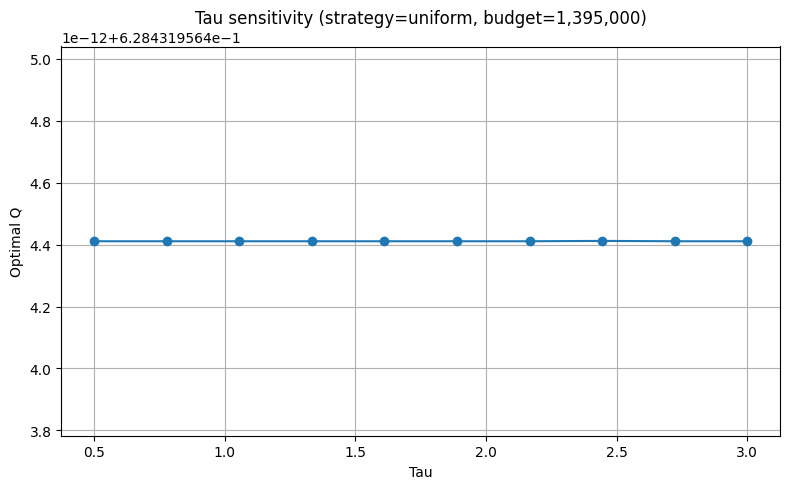

In [ ]:
df_res=pd.read_csv(os.path.join(OUTPUT_DIR, 'tau_sensitivity.csv'))
strategy = 'uniform'
target_budget = 10_600_000
plt.figure(figsize=(8, 5))
feasible = df_res['feasible'] == True
plt.plot(df_res.loc[feasible, 'Tau'], df_res.loc[feasible, 'Q'], marker='o', linestyle='-')
plt.scatter(df_res.loc[~feasible, 'Tau'], np.zeros((~feasible).sum()), marker='x', color='red', label='infeasible')
plt.xlabel('Tau')
plt.ylabel('Optimal Q')
plt.title(f'Tau sensitivity (strategy={strategy}, budget={target_budget:,.0f})')
plt.grid(True)
plt.tight_layout()
plot_path = os.path.join(OUTPUT_DIR, f'Tau_sensitivity_{strategy}_{int(target_budget)}.png')
plt.savefig(plot_path, dpi=200)
print(f"Saved plot to: {plot_path}")

print('\nSummary:')
print(df_res)

In [ ]:
"""
w_commercial_sensitivity.py

Sensitivity analysis for the *commercial* service-level weight while holding all other
category service levels (W_c) equal to fixed baseline values.

Behaviour:
 - For each baseline value in BASE_NON_COMMERCIAL = [0.5,0.6,0.7,0.8,0.9]
 - Set all W_c (except 'commercial') to that baseline value
 - Sweep w_commercial over COMM_GRID (e.g. 0.1..1.2)
 - For each combination, rebuild W_mod and call build_and_solve_model with fixed budget
 - Record feasibility, Q, budget_used, opened stations
 - Save a combined CSV and one CSV per baseline level
 - Produce a single plot containing one curve per baseline where x = w_commercial and y = Q

Assumptions:
 - Your main pipeline (pareto_pipeline_fixed.py) is in the same folder and exposes:
     POIS_PATH, STATIONS_TEMPLATE, DEMAND_TEMPLATE, EXISTING_STATION_DATA,
     Tau, k, W_C, COST_EXISTING, COST_NEW, ALPHA, OUTPUT_DIR,
     haversine_matrix, build_and_solve_model
 - Target budget is set here to 1_240_000 by default. Change if needed.

Usage: python w_commercial_sensitivity.py
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict

# import pipeline constants & helper functions
OUTPUT_DIR = 'pareto_outputs'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------- User settings --------------------
strategy = 'uniform'
# fixed budget used in earlier discussion — change if you prefer
target_budget = 10_600_000

BASE_NON_COMMERCIAL = [0.5, 0.6, 0.7]
COMM_GRID = np.linspace(0.5, 1, 6)  # grid of commercial weights to sweep

# -------------------- Data loader (copied logic from pipeline) --------------------

def load_data_for_strategy(strategy: str):
    pois = pd.read_csv(POIS_PATH)
    stations = pd.read_csv(STATIONS_TEMPLATE.format(strategy))
    D_km = haversine_matrix(pois, stations)

    poi_categories = pois['category'].reset_index(drop=True)
    min_row_idx_for_station = np.argmin(D_km, axis=0)
    station_categories = poi_categories.iloc[min_row_idx_for_station].reset_index(drop=True)
    stations['category'] = station_categories.values

    categories = list(W_C.keys())
    I_c = {c: pois.index[pois['category'] == c].tolist() for c in categories}

    demand_scenarios: List[List[float]] = []
    for i in range(4):
        df = pd.read_csv(DEMAND_TEMPLATE.format(strategy, i))
        demand_scenarios.append(df['demand_per_hour'].tolist())

    existing_data = pd.read_csv(EXISTING_STATION_DATA)
    capacity_map = dict(zip(existing_data['station_id'], existing_data['capacity']))
    capacity_vector = np.array([capacity_map.get(sid, 10) for sid in stations['snapped_station_id']])

    is_existing = stations['is_existing_station'].astype(bool).values
    station_is_commercial_by_nearest = (stations['category'] == 'commercial').values

    return {
        'pois': pois,
        'stations': stations,
        'D_km': D_km,
        'I_c': I_c,
        'demand_scenarios': demand_scenarios,
        'capacity_vector': capacity_vector,
        'is_existing': is_existing,
        'station_is_commercial_by_nearest': station_is_commercial_by_nearest
    }

# -------------------- Sensitivity runner --------------------

def run_w_commercial_sensitivity(strategy: str,
                                 target_budget: float,
                                 base_non_commercial_vals: List[float],
                                 comm_grid: np.ndarray):
    data = load_data_for_strategy(strategy)
    pois = data['pois']
    stations = data['stations']
    D_km = data['D_km']
    I_c = data['I_c']
    demand_scenarios = data['demand_scenarios']
    capacity_vector = data['capacity_vector']
    is_existing = data['is_existing']
    station_is_commercial_by_nearest = data['station_is_commercial_by_nearest']

    J = stations.shape[0]

    # Precompute cost_vector using ALPHA from the pipeline (keeps the same costs across W variations)
    cost_vector = np.zeros(J, dtype=float)
    for j in range(J):
        if is_existing[j] and station_is_commercial_by_nearest[j]:
            cost_vector[j] = ALPHA * COST_EXISTING
        elif is_existing[j]:
            cost_vector[j] = COST_EXISTING
        elif station_is_commercial_by_nearest[j]:
            cost_vector[j] = ALPHA * COST_NEW
        else:
            cost_vector[j] = COST_NEW

    records = []

    for base_val in base_non_commercial_vals:
        print(f"\nRunning baseline for non-commercial W = {base_val:.2f}")
        for w_comm in comm_grid:
            # build W_mod
            W_mod = {c: (base_val if c != 'commercial' else w_comm) for c in W_C.keys()}

            try:
                sol = build_and_solve_model(
                    D_km, stations, pois, demand_scenarios, capacity_vector,
                    cost_vector, I_c, W_mod, Tau, k, float(target_budget), verbose=False
                )
            except Exception as e:
                print(f"Error solving for base={base_val}, w_comm={w_comm}: {e}")
                sol = None

            if sol is None:
                records.append({
                    'base_non_commercial': base_val,
                    'w_commercial': float(w_comm),
                    'feasible': False,
                    'Q': np.nan,
                    'budget_used': np.nan,
                    'opened': np.nan
                })
            else:
                records.append({
                    'base_non_commercial': base_val,
                    'w_commercial': float(w_comm),
                    'feasible': True,
                    'Q': float(sol['Q']),
                    'budget_used': float(sol['budget_used']),
                    'opened': int(sol['opened'])
                })

    df_all = pd.DataFrame(records)
    # save combined
    out_csv = os.path.join(OUTPUT_DIR, f'w_commercial_sensitivity_combined_{strategy}_{int(target_budget)}.csv')
    df_all.to_csv(out_csv, index=False)
    print(f"Saved combined results to: {out_csv}")

    # save per-baseline
    for base_val in base_non_commercial_vals:
        sub = df_all[df_all['base_non_commercial'] == base_val].copy()
        sub.to_csv(os.path.join(OUTPUT_DIR, f'w_commercial_sensitivity_base_{base_val:.2f}_{strategy}_{int(target_budget)}.csv'), index=False)

    return df_all

# -------------------- Plotting --------------------

def plot_w_commercial(df_all: pd.DataFrame, comm_grid: np.ndarray, base_non_commercial_vals: List[float]):
    plt.figure(figsize=(10, 6))
    for base_val in base_non_commercial_vals:
        sub = df_all[(df_all['base_non_commercial'] == base_val) & (df_all['feasible'])]
        if sub.empty:
            continue
        # ensure sorted by w_commercial
        sub = sub.sort_values('w_commercial')
        plt.plot(sub['w_commercial'], sub['Q'], marker='o', label=f'non-comm={base_val:.2f}')

    # mark infeasible combos as red x at y=0 (or below plot) for visibility
    infeas = df_all[~df_all['feasible']]
    if not infeas.empty:
        plt.scatter(infeas['w_commercial'], np.zeros(len(infeas)), marker='x', color='red', label='infeasible')

    plt.xlabel('Commercial service level (W_commercial)')
    plt.ylabel('Optimal Q (km)')
    plt.title(f"Sensitivity of Q to W_commercial (budget={target_budget:,.0f})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    out_png = os.path.join(OUTPUT_DIR, f'w_commercial_sensitivity_plot_{strategy}_{int(target_budget)}.png')
    plt.savefig(out_png, dpi=200)
    print(f"Saved plot to: {out_png}")



Running baseline for non-commercial W = 0.50


/var/folders/tn/v19h6ld131n5p0bkj6b850sr0000gn/T/ipykernel_74936/3864070310.py:79: LicenseWarning: Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
  prob = xp.problem(name='pcentre_modular_run')



Running baseline for non-commercial W = 0.60

Running baseline for non-commercial W = 0.70
Saved combined results to: pareto_outputs/w_commercial_sensitivity_combined_uniform_1395000.csv
Saved plot to: pareto_outputs/w_commercial_sensitivity_plot_uniform_1395000.png

Top rows of results:
   base_non_commercial  w_commercial  feasible         Q  budget_used  opened
0                  0.5           0.5      True  0.216175    1377000.0      22
1                  0.5           0.6      True  0.223559    1380000.0      23
2                  0.5           0.7      True  0.255264    1395000.0      25
3                  0.5           0.8      True  0.292293    1395000.0      24
4                  0.5           0.9      True  0.378619    1380000.0      25


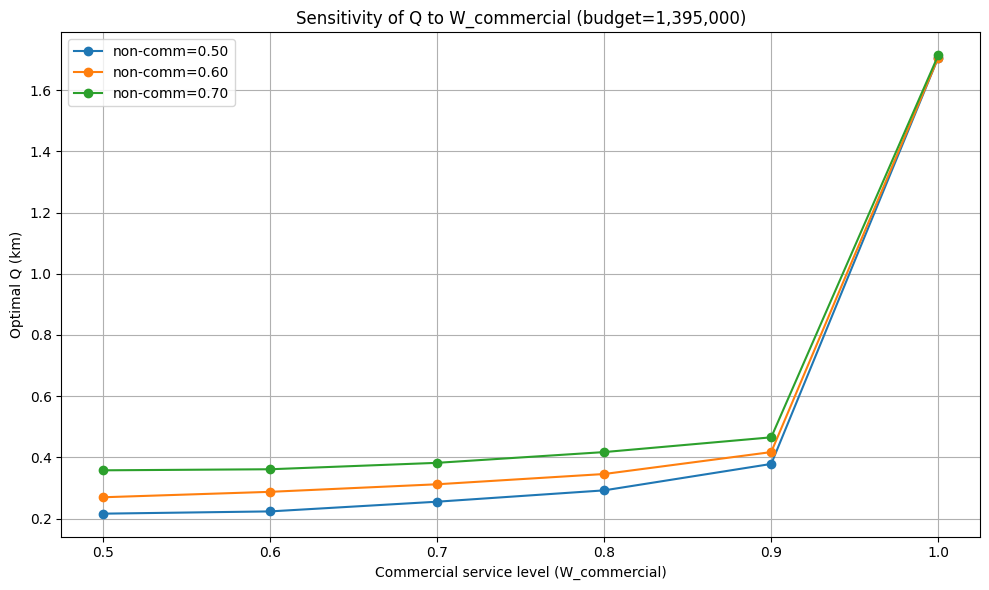

In [ ]:

# -------------------- Main --------------------
if __name__ == '__main__':
    df_results = run_w_commercial_sensitivity(strategy, target_budget, BASE_NON_COMMERCIAL, COMM_GRID)
    plot_w_commercial(df_results, COMM_GRID, BASE_NON_COMMERCIAL)
    print('\nTop rows of results:')
    print(df_results.head())


In [ ]:
"""
alpha_sensitivity_vs_uniform.py

Find values of alpha (cost scaling factor) at which commercial and pred strategies
become more worthwhile than uniform, under a fixed budget.

Comparison rule (Option C - dominance): strategy S is "preferred" over uniform if
both
  Q_S <= Q_uniform and budget_used_S <= budget_used_uniform
and at least one of those inequalities is strict.

Outputs:
 - CSV with alpha, Q and budget for each strategy and boolean flags indicating dominance
 - Plot Q vs alpha for the three strategies with markers where dominance occurs

Usage: python alpha_sensitivity_vs_uniform.py
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict

OUTPUT_DIR = 'pareto_outputs'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------- User settings --------------------
strategy_list = ['uniform', 'commercial', 'pred']
fixed_budget = 10_600_000  # change if you want a different budget
alpha_grid = np.linspace(0.01, 1.0, 15)  # grid of alpha to test

# -------------------- Data loader (copied logic from pipeline) --------------------

def load_data_for_strategy(strategy: str):
    pois = pd.read_csv(POIS_PATH)
    stations = pd.read_csv(STATIONS_TEMPLATE.format(strategy))
    D_km = haversine_matrix(pois, stations)

    poi_categories = pois['category'].reset_index(drop=True)
    min_row_idx_for_station = np.argmin(D_km, axis=0)
    station_categories = poi_categories.iloc[min_row_idx_for_station].reset_index(drop=True)
    stations['category'] = station_categories.values

    categories = list(W_C.keys())
    I_c = {c: pois.index[pois['category'] == c].tolist() for c in categories}

    demand_scenarios: List[List[float]] = []
    for i in range(4):
        df = pd.read_csv(DEMAND_TEMPLATE.format(strategy, i))
        demand_scenarios.append(df['demand_per_hour'].tolist())

    existing_data = pd.read_csv(EXISTING_STATION_DATA)
    capacity_map = dict(zip(existing_data['station_id'], existing_data['capacity']))
    capacity_vector = np.array([capacity_map.get(sid, 10) for sid in stations['snapped_station_id']])

    is_existing = stations['is_existing_station'].astype(bool).values
    station_is_commercial_by_nearest = (stations['category'] == 'commercial').values

    return {
        'pois': pois,
        'stations': stations,
        'D_km': D_km,
        'I_c': I_c,
        'demand_scenarios': demand_scenarios,
        'capacity_vector': capacity_vector,
        'is_existing': is_existing,
        'station_is_commercial_by_nearest': station_is_commercial_by_nearest
    }

# -------------------- helper: build cost vector for alpha --------------------

def build_cost_vector(alpha: float, is_existing: np.ndarray, station_is_commercial_by_nearest: np.ndarray) -> np.ndarray:
    J = len(is_existing)
    cost_vector = np.zeros(J, dtype=float)
    for j in range(J):
        if is_existing[j] and station_is_commercial_by_nearest[j]:
            cost_vector[j] = alpha * COST_EXISTING
        elif is_existing[j]:
            cost_vector[j] = COST_EXISTING
        elif station_is_commercial_by_nearest[j]:
            cost_vector[j] = alpha * COST_NEW
        else:
            cost_vector[j] = COST_NEW
    return cost_vector

# -------------------- run sensitivity --------------------

def run_alpha_dominance_analysis(fixed_budget: float, alpha_grid: np.ndarray):
    # load data for one representative strategy fileset (station files differ by strategy)
    # We need to load stations per strategy because stations CSV path uses strategy name.
    # For fairness we'll load station files separately inside the loop when necessary.

    records = []

    for alpha in alpha_grid:
        row = {'alpha': float(alpha)}
        strategy_results = {}
        for s in strategy_list:
            # load data for this strategy (stations file differs)
            data = load_data_for_strategy(s)
            pois = data['pois']
            stations = data['stations']
            D_km = data['D_km']
            I_c = data['I_c']
            demand_scenarios = data['demand_scenarios']
            capacity_vector = data['capacity_vector']
            is_existing = data['is_existing']
            station_is_commercial_by_nearest = data['station_is_commercial_by_nearest']

            cost_vector = build_cost_vector(alpha, is_existing, station_is_commercial_by_nearest)

            sol = build_and_solve_model(
                D_km, stations, pois, demand_scenarios, capacity_vector,
                cost_vector, I_c, W_C, Tau, k, float(fixed_budget), verbose=False
            )

            if sol is None:
                strategy_results[s] = {'feasible': False, 'Q': np.nan, 'budget_used': np.nan, 'opened': np.nan}
            else:
                strategy_results[s] = {'feasible': True, 'Q': float(sol['Q']), 'budget_used': float(sol['budget_used']), 'opened': int(sol['opened'])}

            # add to row
            row[f'{s}_feasible'] = strategy_results[s]['feasible']
            row[f'{s}_Q'] = strategy_results[s]['Q']
            row[f'{s}_budget_used'] = strategy_results[s]['budget_used']
            row[f'{s}_opened'] = strategy_results[s]['opened']

        # dominance check relative to uniform (Option C)
        # requires feasible for both
        u = strategy_results['uniform']
        for s in ['commercial', 'pred']:
            v = strategy_results[s]
            dominates = False
            if u['feasible'] and v['feasible']:
                leqQ = (v['Q'] <= u['Q'])
                leqB = (v['budget_used'] <= u['budget_used'])
                strict = (v['Q'] < u['Q']) or (v['budget_used'] < u['budget_used'])
                dominates = bool(leqQ and leqB and strict)
            row[f'{s}_dominates_uniform'] = dominates

        records.append(row)
        print(f'alpha={alpha:.3f}: commercial dominates uniform={row["commercial_dominates_uniform"]}, pred dominates uniform={row["pred_dominates_uniform"]}')

    df = pd.DataFrame(records)
    return df

# -------------------- plotting & reporting --------------------

def plot_results(df: pd.DataFrame, out_prefix: str):
    plt.figure(figsize=(10,6))
    for s in strategy_list:
        feasible_mask = df[f'{s}_feasible'] == True
        plt.plot(df.loc[feasible_mask, 'alpha'], df.loc[feasible_mask, f'{s}_Q'], marker='o', label=s)
    # mark alphas where dominance occurs
    comm_dom = df[df['commercial_dominates_uniform'] == True]['alpha']
    pred_dom = df[df['pred_dominates_uniform'] == True]['alpha']
    if not comm_dom.empty:
        plt.scatter(comm_dom, np.interp(comm_dom, df['alpha'], df['commercial_Q']), color='C1', s=120, marker='*', label='commercial dominates')
    if not pred_dom.empty:
        plt.scatter(pred_dom, np.interp(pred_dom, df['alpha'], df['pred_Q']), color='C2', s=120, marker='P', label='pred dominates')

    plt.xlabel('alpha')
    plt.ylabel('Optimal Q (km)')
    plt.title(f'Alpha sensitivity and dominance vs uniform (budget={fixed_budget:,.0f})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    out_png = os.path.join(OUTPUT_DIR, f'{out_prefix}_alpha_vs_Q.png')
    plt.savefig(out_png, dpi=200)
    print(f'Saved plot to {out_png}')

    # Save CSV
    out_csv = os.path.join(OUTPUT_DIR, f'{out_prefix}_alpha_dominance.csv')
    df.to_csv(out_csv, index=False)
    print(f'Saved CSV to {out_csv}')

    # Report alpha thresholds: first alpha where dominance is True (if any)
    comm_first = df[df['commercial_dominates_uniform'] == True]['alpha']
    pred_first = df[df['pred_dominates_uniform'] == True]['alpha']
    print('Thresholds:')
    print('commercial first dominates at alpha=', float(comm_first.iloc[0]) if not comm_first.empty else 'never in grid')
    print('pred first dominates at alpha=', float(pred_first.iloc[0]) if not pred_first.empty else 'never in grid')

/var/folders/tn/v19h6ld131n5p0bkj6b850sr0000gn/T/ipykernel_66715/3864070310.py:79: LicenseWarning: Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
  prob = xp.problem(name='pcentre_modular_run')


alpha=0.010: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.081: commercial dominates uniform=True, pred dominates uniform=True
alpha=0.151: commercial dominates uniform=True, pred dominates uniform=True
alpha=0.222: commercial dominates uniform=True, pred dominates uniform=True
alpha=0.293: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.364: commercial dominates uniform=False, pred dominates uniform=True
alpha=0.434: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.505: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.576: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.646: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.717: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.788: commercial dominates uniform=False, pred dominates uniform=False
alpha=0.859: commercial dominates uniform=False, pred dominates uniform

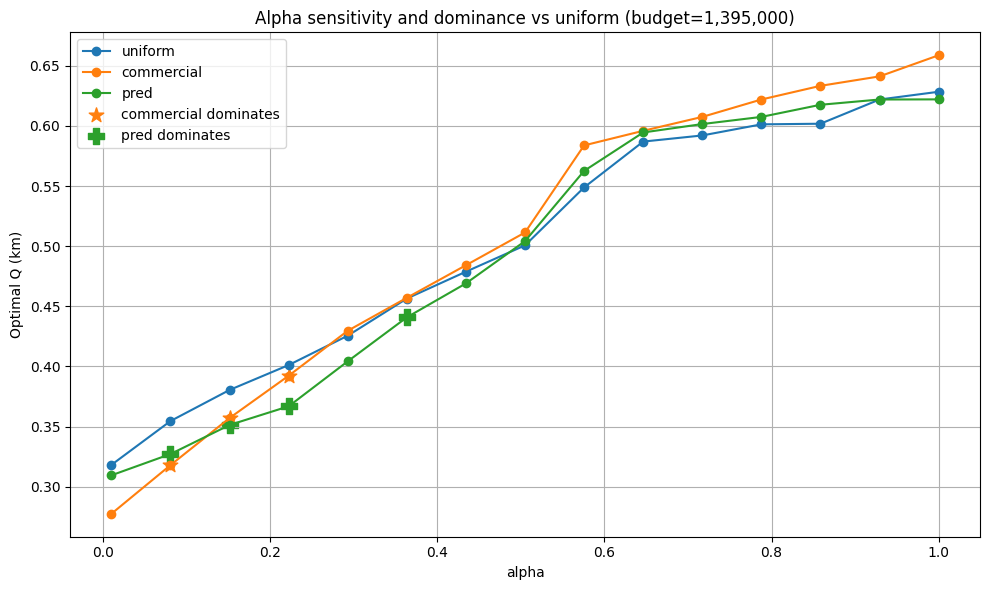

In [ ]:

# -------------------- main --------------------
if __name__ == '__main__':
    df_out = run_alpha_dominance_analysis(fixed_budget, alpha_grid)
    plot_results(df_out, 'strategy_vs_uniform')
    print('Done. Preview:')
    print(df_out.head())
# Full script will be inserted in next update.
